Feature engeneering for RE dataset - R libs

In [106]:
library(data.table)
library(FeatureHashing)
library(Matrix)
library(xgboost)
require(randomForest)
require(caret)
require(dplyr)
require(ggplot2)
library(pROC)
library(stringr)
library(dummies)
library(Metrics)
library(kernlab)
library(mlbench)

testing data cleaning

In [107]:
train <- read.csv("./input/train.csv", stringsAsFactors=FALSE)
test <- read.csv("./input/test.csv", stringsAsFactors=FALSE)

In [108]:
head(train)

Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,⋯,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,⋯,0,NA,NA,NA,0,2,2008,WD,Normal,208500
2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,⋯,0,NA,NA,NA,0,5,2007,WD,Normal,181500
3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,NA,NA,0,9,2008,WD,Normal,223500
4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,NA,NA,0,12,2008,WD,Normal,250000
6,50,RL,85,14115,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,MnPrv,Shed,700,10,2009,WD,Normal,143000


In [109]:
names(train)

[1] "Id"            "MSSubClass"    "MSZoning"      "LotFrontage"  
 [5] "LotArea"       "Street"        "Alley"         "LotShape"     
 [9] "LandContour"   "Utilities"     "LotConfig"     "LandSlope"    
[13] "Neighborhood"  "Condition1"    "Condition2"    "BldgType"     
[17] "HouseStyle"    "OverallQual"   "OverallCond"   "YearBuilt"    
[21] "YearRemodAdd"  "RoofStyle"     "RoofMatl"      "Exterior1st"  
[25] "Exterior2nd"   "MasVnrType"    "MasVnrArea"    "ExterQual"    
[29] "ExterCond"     "Foundation"    "BsmtQual"      "BsmtCond"     
[33] "BsmtExposure"  "BsmtFinType1"  "BsmtFinSF1"    "BsmtFinType2" 
[37] "BsmtFinSF2"    "BsmtUnfSF"     "TotalBsmtSF"   "Heating"      
[41] "HeatingQC"     "CentralAir"    "Electrical"    "X1stFlrSF"    
[45] "X2ndFlrSF"     "LowQualFinSF"  "GrLivArea"     "BsmtFullBath" 
[49] "BsmtHalfBath"  "FullBath"      "HalfBath"      "BedroomAbvGr" 
[53] "KitchenAbvGr"  "KitchenQual"   "TotRmsAbvGrd"  "Functional"   
[57] "Fireplaces"    "FireplaceQu"   "GarageType"    "GarageYrBlt"  
[61] "GarageFinish"  "GarageCars"    "GarageArea"    "GarageQual"   
[65] "GarageCond"    "PavedDrive"    "WoodDeckSF"    "OpenPorchSF"  
[69] "EnclosedPorch" "X3SsnPorch"    "ScreenPorch"   "PoolArea"     
[73] "PoolQC"        "Fence"         "MiscFeature"   "MiscVal"      
[77] "MoSold"        "YrSold"        "SaleType"      "SaleCondition"
[81] "SalePrice"

reformatting char variables

In [110]:
table(train$Street)


Grvl Pave 
   6 1454 

it shows that it could make sense to make it categorical (2 categories)

In [111]:
train$pave[train$Street == "Pave"] <- 1
train$pave[train$Street != "Pave"] <- 0

It seems that most of values are in RL class so maybe it makes sense to transform it to bi valued feature

In [112]:
train$regshape[train$LotShape == "Reg"] <- 1
train$regshape[train$LotShape != "Reg"] <- 0

In [113]:
train$flat[train$LandContour == "Lvl"] <- 1
train$flat[train$LandContour != "Lvl"] <- 0

train$pubutil[train$Utilities == "AllPub"] <- 1
train$pubutil[train$Utilities != "AllPub"] <- 0

train$gentle_slope[train$LandSlope == "Gtl"] <- 1
train$gentle_slope[train$LandSlope != "Gtl"] <- 0

# summarize(group_by(train, LotConfig),
#           mean(SalePrice, na.rm=T))

train$culdesac_fr3[train$LandSlope %in% c("CulDSac", "FR3")] <- 1
train$culdesac_fr3[!train$LandSlope %in% c("CulDSac", "FR3")] <- 0

nbhdprice <- summarize(group_by(train, Neighborhood),
          mean(SalePrice, na.rm=T))

#nbhdprice[order(nbhdprice$`mean(SalePrice, na.rm = T)`),]

nbhdprice_lo <- filter(nbhdprice, nbhdprice$`mean(SalePrice, na.rm = T)` < 140000)
nbhdprice_med <- filter(nbhdprice, nbhdprice$`mean(SalePrice, na.rm = T)` < 200000 &
                          nbhdprice$`mean(SalePrice, na.rm = T)` >= 140000 )
nbhdprice_hi <- filter(nbhdprice, nbhdprice$`mean(SalePrice, na.rm = T)` >= 200000)

train$nbhd_price_level[train$Neighborhood %in% nbhdprice_lo$Neighborhood] <- 1
train$nbhd_price_level[train$Neighborhood %in% nbhdprice_med$Neighborhood] <- 2
train$nbhd_price_level[train$Neighborhood %in% nbhdprice_hi$Neighborhood] <- 3

# summarize(group_by(train, Condition1),
#           mean(SalePrice, na.rm=T))

train$pos_features_1[train$Condition1 %in% c("PosA", "PosN")] <- 1
train$pos_features_1[!train$Condition1 %in% c("PosA", "PosN")] <- 0

# summarize(group_by(train, Condition2),
#           mean(SalePrice, na.rm=T))

train$pos_features_2[train$Condition1 %in% c("PosA", "PosN")] <- 1
train$pos_features_2[!train$Condition1 %in% c("PosA", "PosN")] <- 0

# summarize(group_by(train, BldgType),
#           mean(SalePrice, na.rm=T))

train$twnhs_end_or_1fam[train$BldgType %in% c("1Fam", "TwnhsE")] <- 1
train$twnhs_end_or_1fam[!train$BldgType %in% c("1Fam", "TwnhsE")] <- 0

housestyle_price <- summarize(group_by(train, HouseStyle),
          mean(SalePrice, na.rm=T))

housestyle_lo <- filter(housestyle_price, housestyle_price$`mean(SalePrice, na.rm = T)` < 140000)
housestyle_med <- filter(housestyle_price, housestyle_price$`mean(SalePrice, na.rm = T)` < 200000 &
                          housestyle_price$`mean(SalePrice, na.rm = T)` >= 140000 )
housestyle_hi <- filter(housestyle_price, housestyle_price$`mean(SalePrice, na.rm = T)` >= 200000)

train$house_style_level[train$HouseStyle %in% housestyle_lo$HouseStyle] <- 1
train$house_style_level[train$HouseStyle %in% housestyle_med$HouseStyle] <- 2
train$house_style_level[train$HouseStyle %in% housestyle_hi$HouseStyle] <- 3


roofstyle_price <- summarize(group_by(train, RoofStyle),
          mean(SalePrice, na.rm=T))

train$roof_hip_shed[train$RoofStyle %in% c("Hip", "Shed")] <- 1
train$roof_hip_shed[!train$RoofStyle %in% c("Hip", "Shed")] <- 0

roofmatl_price <- summarize(group_by(train, RoofMatl),
          mean(SalePrice, na.rm=T))

train$roof_matl_hi[train$RoofMatl %in% c("Membran", "WdShake", "WdShngl")] <- 1
train$roof_matl_hi[!train$RoofMatl %in% c("Membran", "WdShake", "WdShngl")] <- 0


price <- summarize(group_by(train, Exterior1st),
          mean(SalePrice, na.rm=T))

matl_lo_1 <- filter(price, price$`mean(SalePrice, na.rm = T)` < 140000)
matl_med_1<- filter(price, price$`mean(SalePrice, na.rm = T)` < 200000 &
                          price$`mean(SalePrice, na.rm = T)` >= 140000 )
matl_hi_1 <- filter(price, price$`mean(SalePrice, na.rm = T)` >= 200000)

train$exterior_1[train$Exterior1st %in% matl_lo_1$Exterior1st] <- 1
train$exterior_1[train$Exterior1st %in% matl_med_1$Exterior1st] <- 2
train$exterior_1[train$Exterior1st %in% matl_hi_1$Exterior1st] <- 3


price <- summarize(group_by(train, Exterior2nd),
          mean(SalePrice, na.rm=T))

matl_lo <- filter(price, price$`mean(SalePrice, na.rm = T)` < 140000)
matl_med <- filter(price, price$`mean(SalePrice, na.rm = T)` < 200000 &
                          price$`mean(SalePrice, na.rm = T)` >= 140000 )
matl_hi <- filter(price, price$`mean(SalePrice, na.rm = T)` >= 200000)

train$exterior_2[train$Exterior2nd %in% matl_lo$Exterior2nd] <- 1
train$exterior_2[train$Exterior2nd %in% matl_med$Exterior2nd] <- 2
train$exterior_2[train$Exterior2nd %in% matl_hi$Exterior2nd] <- 3

price <- summarize(group_by(train, MasVnrType),
          mean(SalePrice, na.rm=T))

train$exterior_mason_1[train$MasVnrType %in% c("Stone", "BrkFace") | is.na(train$MasVnrType)] <- 1
train$exterior_mason_1[!train$MasVnrType %in% c("Stone", "BrkFace") & !is.na(train$MasVnrType)] <- 0


price <- summarize(group_by(train, ExterQual),
          mean(SalePrice, na.rm=T))

train$exterior_cond[train$ExterQual == "Ex"] <- 4
train$exterior_cond[train$ExterQual == "Gd"] <- 3
train$exterior_cond[train$ExterQual == "TA"] <- 2
train$exterior_cond[train$ExterQual == "Fa"] <- 1


price <- summarize(group_by(train, ExterCond),
          mean(SalePrice, na.rm=T))

train$exterior_cond2[train$ExterCond == "Ex"] <- 5
train$exterior_cond2[train$ExterCond == "Gd"] <- 4
train$exterior_cond2[train$ExterCond == "TA"] <- 3
train$exterior_cond2[train$ExterCond == "Fa"] <- 2
train$exterior_cond2[train$ExterCond == "Po"] <- 1


price <- summarize(group_by(train, Foundation),
          mean(SalePrice, na.rm=T))

train$found_concrete[train$Foundation == "PConc"] <- 1
train$found_concrete[train$Foundation != "PConc"] <- 0


price <- summarize(group_by(train, BsmtQual),
          mean(SalePrice, na.rm=T))

train$bsmt_cond1[train$BsmtQual == "Ex"] <- 5
train$bsmt_cond1[train$BsmtQual == "Gd"] <- 4
train$bsmt_cond1[train$BsmtQual == "TA"] <- 3
train$bsmt_cond1[train$BsmtQual == "Fa"] <- 2
train$bsmt_cond1[is.na(train$BsmtQual)] <- 1


price <- summarize(group_by(train, BsmtCond),
          mean(SalePrice, na.rm=T))

train$bsmt_cond2[train$BsmtCond == "Gd"] <- 5
train$bsmt_cond2[train$BsmtCond == "TA"] <- 4
train$bsmt_cond2[train$BsmtCond == "Fa"] <- 3
train$bsmt_cond2[is.na(train$BsmtCond)] <- 2
train$bsmt_cond2[train$BsmtCond == "Po"] <- 1


price <- summarize(group_by(train, BsmtExposure),
          mean(SalePrice, na.rm=T))

train$bsmt_exp[train$BsmtExposure == "Gd"] <- 5
train$bsmt_exp[train$BsmtExposure == "Av"] <- 4
train$bsmt_exp[train$BsmtExposure == "Mn"] <- 3
train$bsmt_exp[train$BsmtExposure == "No"] <- 2
train$bsmt_exp[is.na(train$BsmtExposure)] <- 1


price <- summarize(group_by(train, BsmtFinType1),
          mean(SalePrice, na.rm=T))

train$bsmt_fin1[train$BsmtFinType1 == "GLQ"] <- 5
train$bsmt_fin1[train$BsmtFinType1 == "Unf"] <- 4
train$bsmt_fin1[train$BsmtFinType1 == "ALQ"] <- 3
train$bsmt_fin1[train$BsmtFinType1 %in% c("BLQ", "Rec", "LwQ")] <- 2
train$bsmt_fin1[is.na(train$BsmtFinType1)] <- 1



price <- summarize(group_by(train, BsmtFinType2),
          mean(SalePrice, na.rm=T))

train$bsmt_fin2[train$BsmtFinType2 == "ALQ"] <- 6
train$bsmt_fin2[train$BsmtFinType2 == "Unf"] <- 5
train$bsmt_fin2[train$BsmtFinType2 == "GLQ"] <- 4
train$bsmt_fin2[train$BsmtFinType2 %in% c("Rec", "LwQ")] <- 3
train$bsmt_fin2[train$BsmtFinType2 == "BLQ"] <- 2
train$bsmt_fin2[is.na(train$BsmtFinType2)] <- 1

price <- summarize(group_by(train, Heating),
          mean(SalePrice, na.rm=T))


train$gasheat[train$Heating %in% c("GasA", "GasW")] <- 1
train$gasheat[!train$Heating %in% c("GasA", "GasW")] <- 0


price <- summarize(group_by(train, HeatingQC),
          mean(SalePrice, na.rm=T))

train$heatqual[train$HeatingQC == "Ex"] <- 5
train$heatqual[train$HeatingQC == "Gd"] <- 4
train$heatqual[train$HeatingQC == "TA"] <- 3
train$heatqual[train$HeatingQC == "Fa"] <- 2
train$heatqual[train$HeatingQC == "Po"] <- 1


price <- summarize(group_by(train, CentralAir),
          mean(SalePrice, na.rm=T))

train$air[train$CentralAir == "Y"] <- 1
train$air[train$CentralAir == "N"] <- 0


price <- summarize(group_by(train, Electrical),
          mean(SalePrice, na.rm=T))

train$standard_electric[train$Electrical == "SBrkr" | is.na(train$Electrical)] <- 1
train$standard_electric[!train$Electrical == "SBrkr" & !is.na(train$Electrical)] <- 0


price <- summarize(group_by(train, KitchenQual),
          mean(SalePrice, na.rm=T))

train$kitchen[train$KitchenQual == "Ex"] <- 4
train$kitchen[train$KitchenQual == "Gd"] <- 3
train$kitchen[train$KitchenQual == "TA"] <- 2
train$kitchen[train$KitchenQual == "Fa"] <- 1


price <- summarize(group_by(train, FireplaceQu),
          mean(SalePrice, na.rm=T))

train$fire[train$FireplaceQu == "Ex"] <- 5
train$fire[train$FireplaceQu == "Gd"] <- 4
train$fire[train$FireplaceQu == "TA"] <- 3
train$fire[train$FireplaceQu == "Fa"] <- 2
train$fire[train$FireplaceQu == "Po" | is.na(train$FireplaceQu)] <- 1


price <- summarize(group_by(train, GarageType),
          mean(SalePrice, na.rm=T))

train$gar_attach[train$GarageType %in% c("Attchd", "BuiltIn")] <- 1
train$gar_attach[!train$GarageType %in% c("Attchd", "BuiltIn")] <- 0


price <- summarize(group_by(train, GarageFinish),
          mean(SalePrice, na.rm=T))

train$gar_finish[train$GarageFinish %in% c("Fin", "RFn")] <- 1
train$gar_finish[!train$GarageFinish %in% c("Fin", "RFn")] <- 0


price <- summarize(group_by(train, GarageQual),
          mean(SalePrice, na.rm=T))

train$garqual[train$GarageQual == "Ex"] <- 5
train$garqual[train$GarageQual == "Gd"] <- 4
train$garqual[train$GarageQual == "TA"] <- 3
train$garqual[train$GarageQual == "Fa"] <- 2
train$garqual[train$GarageQual == "Po" | is.na(train$GarageQual)] <- 1



price <- summarize(group_by(train, GarageCond),
          mean(SalePrice, na.rm=T))

train$garqual2[train$GarageCond == "Ex"] <- 5
train$garqual2[train$GarageCond == "Gd"] <- 4
train$garqual2[train$GarageCond == "TA"] <- 3
train$garqual2[train$GarageCond == "Fa"] <- 2
train$garqual2[train$GarageCond == "Po" | is.na(train$GarageCond)] <- 1


price <- summarize(group_by(train, PavedDrive),
          mean(SalePrice, na.rm=T))

train$paved_drive[train$PavedDrive == "Y"] <- 1
train$paved_drive[!train$PavedDrive != "Y"] <- 0
train$paved_drive[is.na(train$paved_drive)] <- 0


price <- summarize(group_by(train, Functional),
          mean(SalePrice, na.rm=T))

train$housefunction[train$Functional %in% c("Typ", "Mod")] <- 1
train$housefunction[!train$Functional %in% c("Typ", "Mod")] <- 0


price <- summarize(group_by(train, PoolQC),
          mean(SalePrice, na.rm=T))

train$pool_good[train$PoolQC %in% c("Ex")] <- 1
train$pool_good[!train$PoolQC %in% c("Ex")] <- 0


price <- summarize(group_by(train, Fence),
          mean(SalePrice, na.rm=T))

train$priv_fence[train$Fence %in% c("GdPrv")] <- 1
train$priv_fence[!train$Fence %in% c("GdPrv")] <- 0


price <- summarize(group_by(train, MiscFeature),
          mean(SalePrice, na.rm=T))
#This doesn't seem worth using at the moment. May adjust later.


price <- summarize(group_by(train, SaleType),
          mean(SalePrice, na.rm=T))

# price[order(price$`mean(SalePrice, na.rm = T)`),]

train$sale_cat[train$SaleType %in% c("New", "Con")] <- 5
train$sale_cat[train$SaleType %in% c("CWD", "ConLI")] <- 4
train$sale_cat[train$SaleType %in% c("WD")] <- 3
train$sale_cat[train$SaleType %in% c("COD", "ConLw", "ConLD")] <- 2
train$sale_cat[train$SaleType %in% c("Oth")] <- 1


price <- summarize(group_by(train, SaleCondition),
          mean(SalePrice, na.rm=T))

# price[order(price$`mean(SalePrice, na.rm = T)`),]

train$sale_cond[train$SaleCondition %in% c("Partial")] <- 4
train$sale_cond[train$SaleCondition %in% c("Normal", "Alloca")] <- 3
train$sale_cond[train$SaleCondition %in% c("Family","Abnorml")] <- 2
train$sale_cond[train$SaleCondition %in% c("AdjLand")] <- 1


price <- summarize(group_by(train, MSZoning),
          mean(SalePrice, na.rm=T))

# price[order(price$`mean(SalePrice, na.rm = T)`),]

train$zone[train$MSZoning %in% c("FV")] <- 4
train$zone[train$MSZoning %in% c("RL")] <- 3
train$zone[train$MSZoning %in% c("RH","RM")] <- 2
train$zone[train$MSZoning %in% c("C (all)")] <- 1


price <- summarize(group_by(train, Alley),
          mean(SalePrice, na.rm=T))

# price[order(price$`mean(SalePrice, na.rm = T)`),]

train$alleypave[train$Alley %in% c("Pave")] <- 1
train$alleypave[!train$Alley %in% c("Pave")] <- 0



drop transformed columns

In [114]:
train$Street <- NULL
train$LotShape <- NULL
train$LandContour <- NULL
train$Utilities <- NULL
train$LotConfig <- NULL
train$LandSlope <- NULL
train$Neighborhood <- NULL
train$Condition1 <- NULL
train$Condition2 <- NULL
train$BldgType <- NULL
train$HouseStyle <- NULL
train$RoofStyle <- NULL
train$RoofMatl <- NULL

train$Exterior1st <- NULL
train$Exterior2nd <- NULL
train$MasVnrType <- NULL
train$ExterQual <- NULL
train$ExterCond <- NULL

train$Foundation <- NULL
train$BsmtQual <- NULL
train$BsmtCond <- NULL
train$BsmtExposure <- NULL
train$BsmtFinType1 <- NULL
train$BsmtFinType2 <- NULL

train$Heating <- NULL
train$HeatingQC <- NULL
train$CentralAir <- NULL
train$Electrical <- NULL
train$KitchenQual <- NULL
train$FireplaceQu <- NULL

train$GarageType <- NULL
train$GarageFinish <- NULL
train$GarageQual <- NULL
train$GarageCond <- NULL
train$PavedDrive <- NULL

train$Functional <- NULL
train$PoolQC <- NULL
train$Fence <- NULL
train$MiscFeature <- NULL
train$SaleType <- NULL
train$SaleCondition <- NULL
train$MSZoning <- NULL
train$Alley <- NULL
#train$X1stFlrSF <- NULL
#train$TotRmsAbvGrd <- NULL
#train$BsmtFinSF1 <- NULL
#train$X2ndFlrSF <- NULL
#train$GrLivArea <- NULL
#train$FullBath <- NULL
#train$TotalBsmtSF <- NULL
#train$YearRemodAdd <- NULL
#train$YearBuilt <- NULL
#train$GarageCars <- NULL
#train$GarageArea <- NULL
#train$fire <- NULL
#train$exterior_cond <- NULL


In [115]:
tail(train)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,⋯,garqual,garqual2,paved_drive,housefunction,pool_good,priv_fence,sale_cat,sale_cond,zone,alleypave
1455,1455,20,62,7500,7,5,2004,2005,0,410,⋯,3,3,0,1,0,0,3,3,4,1
1456,1456,60,62,7917,6,5,1999,2000,0,0,⋯,3,3,0,1,0,0,3,3,3,0
1457,1457,20,85,13175,6,6,1978,1988,119,790,⋯,3,3,0,0,0,0,3,3,3,0
1458,1458,70,66,9042,7,9,1941,2006,0,275,⋯,3,3,0,1,0,1,3,3,3,0
1459,1459,20,68,9717,5,6,1950,1996,0,49,⋯,3,3,0,1,0,0,3,3,3,0
1460,1460,20,75,9937,5,6,1965,1965,0,830,⋯,3,3,0,1,0,0,3,3,3,0


looking for correlations

Warning message in cor(train[, c(5:60)], use = "everything"):
“the standard deviation is zero”

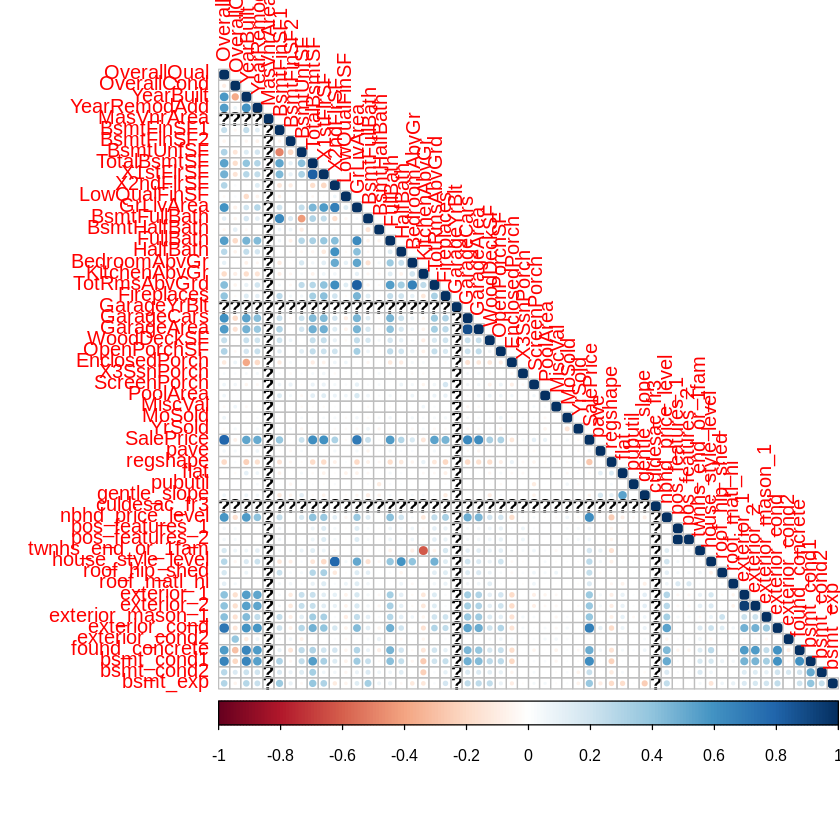

In [116]:
library(corrplot)
correlations <- cor(train[,c(5:60)], use="everything")
corrplot(correlations, method="circle", type="lower",  sig.level = 0.01, insig = "blank")


In [117]:
table(train$GrLivArea)
#X1stFlrSF, TotRmsAbvGrd, BsmtFinSF1,X2ndFlrSF,GrLivArea,FullBath,TotalBsmtSF,YearRemodAdd,YearBuilt


 334  438  480  520  605  616  630  672  691  693  694  698  708  720  729  747 
   1    1    1    1    1    1    6    2    1    1    1    1    1    3    1    2 
 752  754  764  767  768  773  774  778  780  784  788  789  790  792  796  800 
   1    1    1    1    3    1    1    1    1    2    1    2    1    1    2    1 
 803  804  813  816  825  827  832  833  835  838  840  841  845  848  854  858 
   1    1    1    8    1    1    1    2    1    1    1    1    2   10    1    4 
 860  861  864  866  869  872  874  875  882  884  886  892  893  894  899  900 
   1    1   22    1    1    1    1    1    4    1    1    2    1   11    1    3 
 901  902  904  907  910  912  913  914  918  923  924  925  928  930  932  935 
   1    2    3    1    1    9    1    1    1    2    3    1    2    1    1    2 
 936  938  943  944  948  950  951  952  954  955  958  960  964  965  968  969 
   3    1    1    1    3    1    1    3    2    1    3    5    1    1    3    1 
 970  971  972  974  980  9

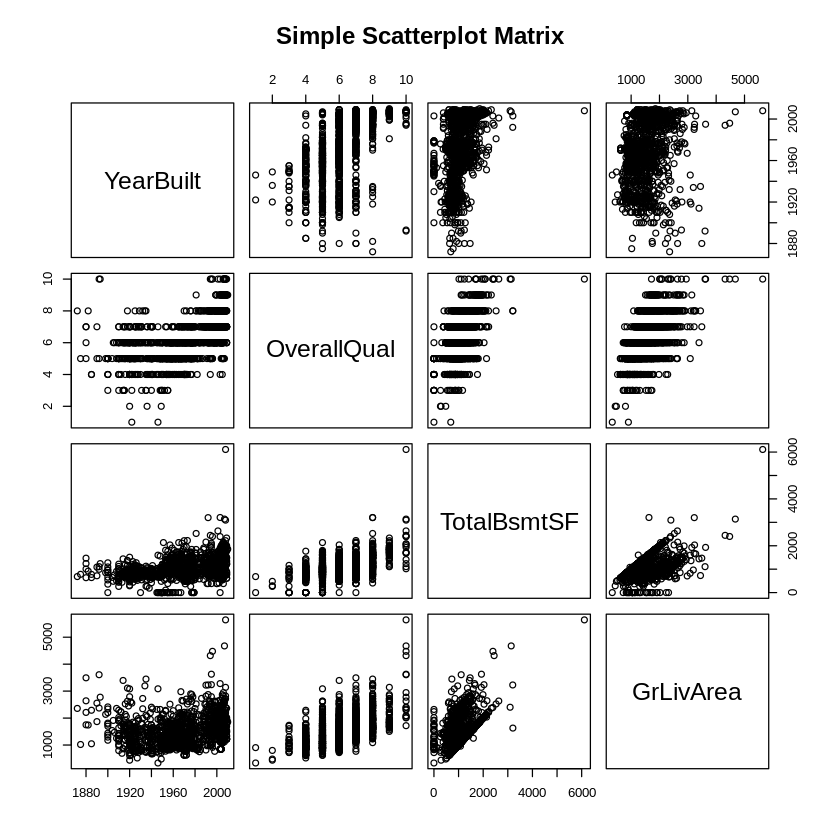

In [118]:
pairs(~YearBuilt+OverallQual+TotalBsmtSF+GrLivArea,data=train,
   main="Simple Scatterplot Matrix")

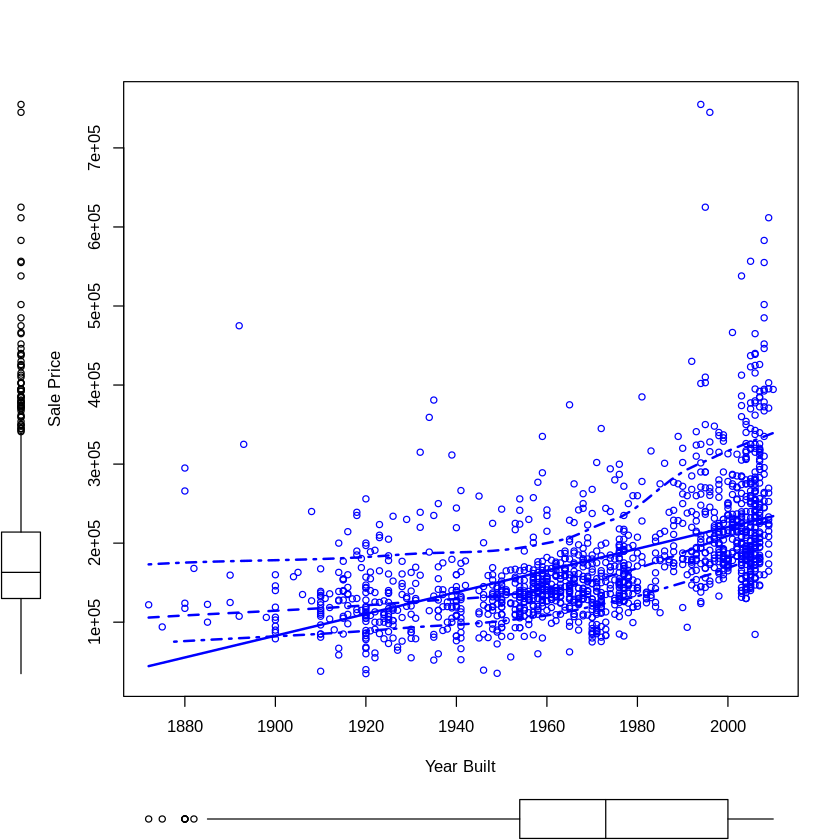

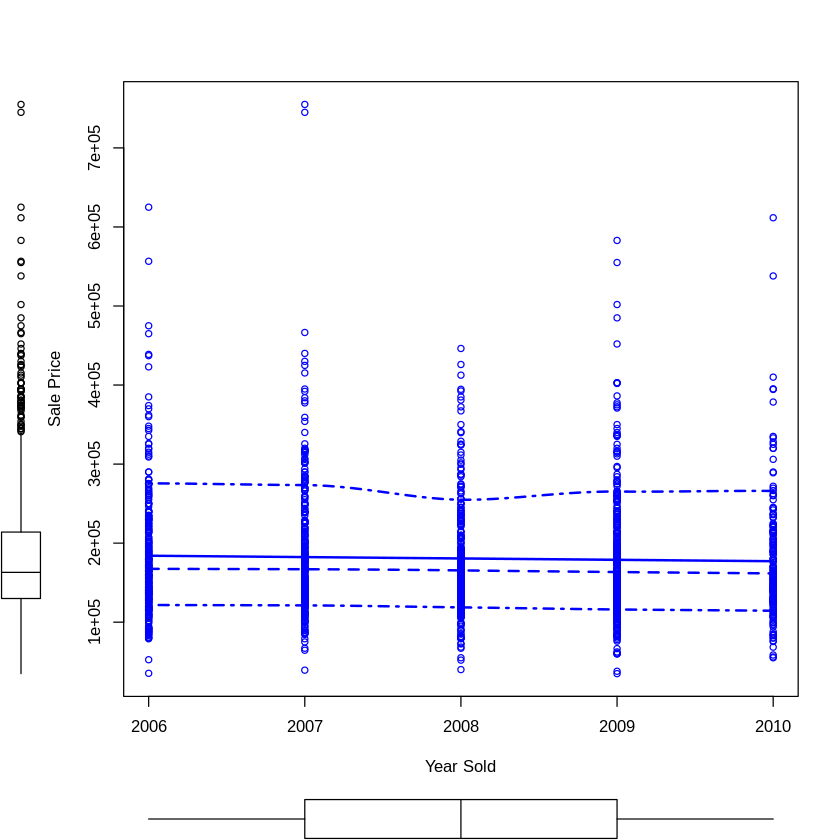

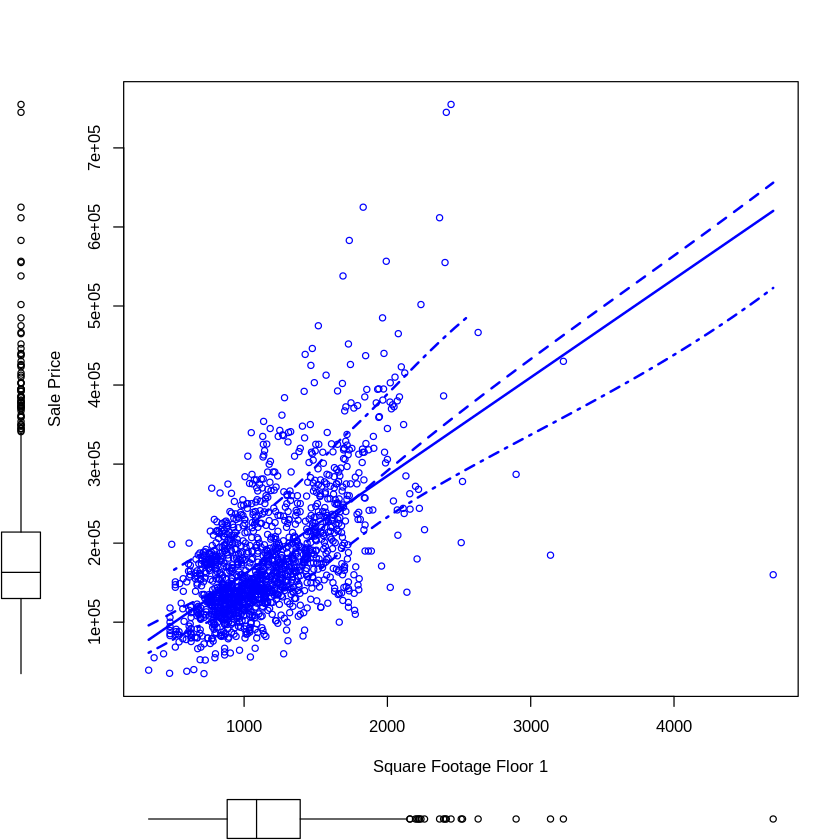

In [119]:
library(car)

scatterplot(SalePrice ~ YearBuilt, data=train,  xlab="Year Built", ylab="Sale Price", grid=FALSE)
scatterplot(SalePrice ~ YrSold, data=train,  xlab="Year Sold", ylab="Sale Price", grid=FALSE)
scatterplot(SalePrice ~ X1stFlrSF, data=train,  xlab="Square Footage Floor 1", ylab="Sale Price", grid=FALSE)

looking for nans in columns

In [120]:
apply(train,2, FUN= function(x) length(which(is.na(x))))

Id        MSSubClass       LotFrontage           LotArea 
                0                 0               259                 0 
      OverallQual       OverallCond         YearBuilt      YearRemodAdd 
                0                 0                 0                 0 
       MasVnrArea        BsmtFinSF1        BsmtFinSF2         BsmtUnfSF 
                8                 0                 0                 0 
      TotalBsmtSF         X1stFlrSF         X2ndFlrSF      LowQualFinSF 
                0                 0                 0                 0 
        GrLivArea      BsmtFullBath      BsmtHalfBath          FullBath 
                0                 0                 0                 0 
         HalfBath      BedroomAbvGr      KitchenAbvGr      TotRmsAbvGrd 
                0                 0                 0                 0 
       Fireplaces       GarageYrBlt        GarageCars        GarageArea 
                0                81                 0                 0 
       WoodDeckSF       OpenPorchSF     EnclosedPorch        X3SsnPorch 
                0                 0                 0                 0 
      ScreenPorch          PoolArea           MiscVal            MoSold 
                0                 0                 0                 0 
           YrSold         SalePrice              pave          regshape 
                0                 0                 0                 0 
             flat           pubutil      gentle_slope      culdesac_fr3 
                0                 0                 0                 0 
 nbhd_price_level    pos_features_1    pos_features_2 twnhs_end_or_1fam 
                0                 0                 0                 0 
house_style_level     roof_hip_shed      roof_matl_hi        exterior_1 
                0                 0                 0                 0 
       exterior_2  exterior_mason_1     exterior_cond    exterior_cond2 
                0                 0                 0                 0 
   found_concrete        bsmt_cond1        bsmt_cond2          bsmt_exp 
                0                 0                 0                 0 
        bsmt_fin1         bsmt_fin2           gasheat          heatqual 
                0                 0                 0                 0 
              air standard_electric           kitchen              fire 
                0                 0                 0                 0 
       gar_attach        gar_finish           garqual          garqual2 
                0                 0                 0                 0 
      paved_drive     housefunction         pool_good        priv_fence 
                0                 0                 0                 0 
         sale_cat         sale_cond              zone         alleypave 
                0                 0                 0                 0

In [121]:
train$GarageYrBlt[is.na(train$GarageYrBlt)] <- 0
train$MasVnrArea[is.na(train$MasVnrArea)] <- 0
train$LotFrontage[is.na(train$LotFrontage)] <- 0

In [122]:
#new features based on correlations
train$year_qual <- train$YearBuilt*train$OverallQual #overall condition
train$year_r_qual <- train$YearRemodAdd*train$OverallQual #quality x remodel
train$qual_bsmt <- train$OverallQual*train$TotalBsmtSF #quality x basement size

train$livarea_qual <- train$OverallQual*train$GrLivArea #quality x living area
train$qual_bath <- train$OverallQual*train$FullBath #quality x baths

train$qual_ext <- train$OverallQual*train$exterior_cond #quality x exterior


In [123]:
#partitioning data
outcome <- train$SalePrice

partition <- createDataPartition(y=outcome,
                                 p=.5,
                                 list=F)
training <- train[partition,]
testing <- train[-partition,]

In [124]:
#some modeling

lm_model_15 <- lm(SalePrice ~ ., data=training)
summary(lm_model_15)


Call:
lm(formula = SalePrice ~ ., data = training)

Residuals:
   Min     1Q Median     3Q    Max 
-86393 -10368    722   9718 149875 

Coefficients: (5 not defined because of singularities)
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        2.199e+06  1.346e+06   1.633 0.102954    
Id                -6.492e-01  1.885e+00  -0.344 0.730678    
MSSubClass        -9.257e+01  2.983e+01  -3.103 0.001998 ** 
LotFrontage       -4.405e+00  2.690e+01  -0.164 0.869976    
LotArea            4.469e-01  7.590e-02   5.888 6.29e-09 ***
OverallQual       -2.947e+05  1.003e+05  -2.937 0.003434 ** 
OverallCond        5.445e+03  1.030e+03   5.289 1.68e-07 ***
YearBuilt          2.686e+02  1.818e+02   1.478 0.139981    
YearRemodAdd      -7.285e+02  2.909e+02  -2.505 0.012502 *  
MasVnrArea        -7.796e-01  6.398e+00  -0.122 0.903056    
BsmtFinSF1        -1.908e+01  1.243e+01  -1.535 0.125185    
BsmtFinSF2        -2.216e+01  1.296e+01  -1.710 0.087652 .  
BsmtUnfSF      

In [125]:
subset(varImp(lm_model_15, scale = FALSE),Overall>1.2)

,Overall
MSSubClass,3.103152
LotArea,5.887513
OverallQual,2.936750
OverallCond,5.288793
YearBuilt,1.477669
YearRemodAdd,2.504629
BsmtFinSF1,1.535349
BsmtFinSF2,1.710492
BsmtUnfSF,3.076016
X1stFlrSF,2.225565


In [126]:
#simplicity - shorter list of vars with best pvalues
vars <- c("MSSubClass",
    "LotArea",
  "BsmtUnfSF",
        "X1stFlrSF",
          "X2ndFlrSF",
          "GarageCars",
"WoodDeckSF",
"nbhd_price_level",
          "exterior_cond",
"pos_features_1",
          "bsmt_exp",
          "kitchen",
          "housefunction",
          "sale_cond",
"qual_ext",
          "qual_bsmt",
"SalePrice")

#testing model with fewer variables
lm_model_simple <- lm(SalePrice ~ ., data=training[,vars])
summary(lm_model_simple)


Call:
lm(formula = SalePrice ~ ., data = training[, vars])

Residuals:
   Min     1Q Median     3Q    Max 
-98264 -13343    623  13147 194237 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -7.265e+04  1.142e+04  -6.363 3.54e-10 ***
MSSubClass       -1.456e+02  2.490e+01  -5.847 7.64e-09 ***
LotArea           3.128e-01  8.019e-02   3.900 0.000105 ***
BsmtUnfSF        -2.575e+01  2.513e+00 -10.247  < 2e-16 ***
X1stFlrSF         5.246e+01  5.220e+00  10.050  < 2e-16 ***
X2ndFlrSF         6.468e+01  2.694e+00  24.007  < 2e-16 ***
GarageCars        6.281e+03  1.668e+03   3.766 0.000180 ***
WoodDeckSF        4.077e+00  8.262e+00   0.493 0.621857    
nbhd_price_level  8.165e+03  1.710e+03   4.773 2.20e-06 ***
exterior_cond    -1.043e+04  5.444e+03  -1.915 0.055882 .  
pos_features_1    2.085e+03  6.720e+03   0.310 0.756518    
bsmt_exp          4.986e+03  1.053e+03   4.735 2.65e-06 ***
kitchen           7.907e+03  2.167e+03   3.648 0.000284 ***
h

In [127]:

lm_model_15 <- lm(SalePrice ~ MSSubClass+LotArea+BsmtUnfSF+
                    X1stFlrSF+X2ndFlrSF+GarageCars+
                    WoodDeckSF+nbhd_price_level+
                    exterior_cond+pos_features_1+
                    bsmt_exp+kitchen+housefunction+pool_good+sale_cond+
                    qual_ext+qual_bsmt, data=training)
summary(lm_model_15)


Call:
lm(formula = SalePrice ~ MSSubClass + LotArea + BsmtUnfSF + X1stFlrSF + 
    X2ndFlrSF + GarageCars + WoodDeckSF + nbhd_price_level + 
    exterior_cond + pos_features_1 + bsmt_exp + kitchen + housefunction + 
    pool_good + sale_cond + qual_ext + qual_bsmt, data = training)

Residuals:
    Min      1Q  Median      3Q     Max 
-136639  -13098     873   12882  189184 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -7.421e+04  1.133e+04  -6.551 1.09e-10 ***
MSSubClass       -1.458e+02  2.469e+01  -5.905 5.45e-09 ***
LotArea           3.137e-01  7.950e-02   3.946 8.74e-05 ***
BsmtUnfSF        -2.432e+01  2.521e+00  -9.648  < 2e-16 ***
X1stFlrSF         5.260e+01  5.175e+00  10.166  < 2e-16 ***
X2ndFlrSF         6.253e+01  2.735e+00  22.865  < 2e-16 ***
GarageCars        6.487e+03  1.654e+03   3.921 9.68e-05 ***
WoodDeckSF        6.834e+00  8.225e+00   0.831 0.406268    
nbhd_price_level  8.459e+03  1.698e+03   4.983 7.87e-07 ***
exterio

In [128]:
#comparing predicted logaritmic price and real price 
prediction <- predict(lm_model_15, testing, type="response")
model_output <- cbind(testing, prediction)

model_output$log_prediction <- log(model_output$prediction)
model_output$log_SalePrice <- log(model_output$SalePrice)

In [129]:
rmse(model_output$log_SalePrice,model_output$log_prediction)


[1] 0.1687955

In [130]:
#checking if random forest is any better than this
model_1 <- randomForest(SalePrice ~ ., data=training, na.action=na.roughfix)
prediction <- predict(model_1, testing)
model_output <- cbind(testing, prediction)
model_output$log_prediction <- log(model_output$prediction)
model_output$log_SalePrice <- log(model_output$SalePrice)
#Test with RMSE
rmse(na.omit(model_output$log_SalePrice),na.omit(model_output$log_prediction))

[1] 0.1448191

In [131]:
#Assemble and format the data

training$log_SalePrice <- log(training$SalePrice)
testing$log_SalePrice <- log(testing$SalePrice)

#Create matrices from the data frames
trainData<- as.matrix(training, rownames.force=NA)
testData<- as.matrix(testing, rownames.force=NA)

#Turn the matrices into sparse matrices
train2 <- as(trainData, "sparseMatrix")
test2 <- as(testData, "sparseMatrix")

#####
#colnames(train2)
#Cross Validate the model

vars <- c(2:37, 39:86) #choose the columns we want to use in the prediction matrix

trainD <- xgb.DMatrix(data = train2[,vars], label = train2[,"SalePrice"]) #Convert to xgb.DMatrix format

#Cross validate the model
cv.sparse <- xgb.cv(data = trainD,
                    nrounds = 600,
                    min_child_weight = 0,
                    max_depth = 10,
                    eta = 0.02,
                    subsample = .7,
                    colsample_bytree = .7,
                    booster = "gbtree",
                    eval_metric = "rmse",
                    verbose = TRUE,
                    print_every_n = 50,
                    nfold = 4,
                    nthread = 2,
                    objective="reg:linear")

#Train the model

#Choose the parameters for the model
param <- list(colsample_bytree = .7,
             subsample = .7,
             booster = "gbtree",
             max_depth = 10,
             eta = 0.02,
             eval_metric = "rmse",
             objective="reg:linear")


#Train the model using those parameters
bstSparse <-
  xgb.train(params = param,
            data = trainD,
            nrounds = 600,
            watchlist = list(train = trainD),
            verbose = TRUE,
            print_every_n = 50,
            nthread = 2)


[1]	train-rmse:192611.957031+1514.130299	test-rmse:192582.734375+4623.521543 
[51]	train-rmse:77047.382812+1190.896379	test-rmse:79678.154297+6509.608369 
[101]	train-rmse:34001.143554+1291.507377	test-rmse:41173.396485+7310.913283 
[151]	train-rmse:17035.238770+1295.254265	test-rmse:29997.822754+7014.617670 
[201]	train-rmse:9683.599732+1091.362663	test-rmse:27056.641601+6457.521270 
[251]	train-rmse:6148.500000+948.157310	test-rmse:26208.505371+5923.909483 
[301]	train-rmse:4276.822693+775.534476	test-rmse:26036.224121+5547.219744 
[351]	train-rmse:3048.572632+561.004223	test-rmse:25994.709473+5339.791547 
[401]	train-rmse:2256.587738+393.845897	test-rmse:25985.894531+5225.317315 
[451]	train-rmse:1716.367584+292.092551	test-rmse:25999.925293+5150.007585 
[501]	train-rmse:1293.291428+206.998352	test-rmse:26026.717774+5109.893053 
[551]	train-rmse:987.155868+160.914980	test-rmse:26036.378418+5091.304351 
[600]	train-rmse:762.639679+126.623626	test-rmse:26049.660156+5077.807777 
[1]	tr

In [132]:
testD <- xgb.DMatrix(data = test2[,vars])
#Column names must match the inputs EXACTLY
prediction <- predict(bstSparse, testD) #Make the prediction based on the half of the training data set aside

#Put testing prediction and test dataset all together
test3 <- as.data.frame(as.matrix(test2))
prediction <- as.data.frame(as.matrix(prediction))
colnames(prediction) <- "prediction"
model_output <- cbind(test3, prediction)

model_output$log_prediction <- log(model_output$prediction)
model_output$log_SalePrice <- log(model_output$SalePrice)

#Test with RMSE

rmse(model_output$log_SalePrice,model_output$log_prediction)

[1] 0.1406692

In [133]:
#STEPS BEFORE SUBMISSION
rm(bstSparse)

#Create matrices from the data frames
retrainData<- as.matrix(train, rownames.force=NA)

#Turn the matrices into sparse matrices
retrain <- as(retrainData, "sparseMatrix")

param <- list(colsample_bytree = .7,
             subsample = .7,
             booster = "gbtree",
             max_depth = 10,
             eta = 0.02,
             eval_metric = "rmse",
             objective="reg:linear")

retrainD <- xgb.DMatrix(data = retrain[,vars], label = retrain[,"SalePrice"])

#retrain the model using those parameters
bstSparse <-
 xgb.train(params = param,
           data = retrainD,
           nrounds = 600,
           watchlist = list(train = trainD),
           verbose = TRUE,
           print_every_n = 50,
           nthread = 2)
  


[1]	train-rmse:192539.171875 
[51]	train-rmse:75375.593750 
[101]	train-rmse:32283.292969 
[151]	train-rmse:15624.268555 
[201]	train-rmse:8766.830078 
[251]	train-rmse:5743.674316 
[301]	train-rmse:4215.971191 
[351]	train-rmse:3384.908203 
[401]	train-rmse:2849.865967 
[451]	train-rmse:2369.360596 
[501]	train-rmse:1979.518921 
[551]	train-rmse:1663.337280 
[600]	train-rmse:1366.037109 


        repeat all the steps for test data

In [134]:
test$paved[test$Street == "Pave"] <- 1
test$paved[test$Street != "Pave"] <- 0

test$regshape[test$LotShape == "Reg"] <- 1
test$regshape[test$LotShape != "Reg"] <- 0

test$flat[test$LandContour == "Lvl"] <- 1
test$flat[test$LandContour != "Lvl"] <- 0

test$pubutil[test$Utilities == "AllPub"] <- 1
test$pubutil[test$Utilities != "AllPub"] <- 0

test$gentle_slope[test$LandSlope == "Gtl"] <- 1
test$gentle_slope[test$LandSlope != "Gtl"] <- 0

test$culdesac_fr3[test$LandSlope %in% c("CulDSac", "FR3")] <- 1
test$culdesac_fr3[!test$LandSlope %in% c("CulDSac", "FR3")] <- 0

test$nbhd_price_level[test$Neighborhood %in% nbhdprice_lo$Neighborhood] <- 1
test$nbhd_price_level[test$Neighborhood %in% nbhdprice_med$Neighborhood] <- 2
test$nbhd_price_level[test$Neighborhood %in% nbhdprice_hi$Neighborhood] <- 3

test$pos_features_1[test$Condition1 %in% c("PosA", "PosN")] <- 1
test$pos_features_1[!test$Condition1 %in% c("PosA", "PosN")] <- 0

test$pos_features_2[test$Condition1 %in% c("PosA", "PosN")] <- 1
test$pos_features_2[!test$Condition1 %in% c("PosA", "PosN")] <- 0


test$twnhs_end_or_1fam[test$BldgType %in% c("1Fam", "TwnhsE")] <- 1
test$twnhs_end_or_1fam[!test$BldgType %in% c("1Fam", "TwnhsE")] <- 0

test$house_style_level[test$HouseStyle %in% housestyle_lo$HouseStyle] <- 1
test$house_style_level[test$HouseStyle %in% housestyle_med$HouseStyle] <- 2
test$house_style_level[test$HouseStyle %in% housestyle_hi$HouseStyle] <- 3


test$roof_hip_shed[test$RoofStyle %in% c("Hip", "Shed")] <- 1
test$roof_hip_shed[!test$RoofStyle %in% c("Hip", "Shed")] <- 0

test$roof_matl_hi[test$RoofMatl %in% c("Membran", "WdShake", "WdShngl")] <- 1
test$roof_matl_hi[!test$RoofMatl %in% c("Membran", "WdShake", "WdShngl")] <- 0

test$exterior_1[test$Exterior1st %in% matl_lo_1$Exterior1st] <- 1
test$exterior_1[test$Exterior1st %in% matl_med_1$Exterior1st] <- 2
test$exterior_1[test$Exterior1st %in% matl_hi_1$Exterior1st] <- 3

test$exterior_2[test$Exterior2nd %in% matl_lo$Exterior2nd] <- 1
test$exterior_2[test$Exterior2nd %in% matl_med$Exterior2nd] <- 2
test$exterior_2[test$Exterior2nd %in% matl_hi$Exterior2nd] <- 3


test$exterior_mason_1[test$MasVnrType %in% c("Stone", "BrkFace") | is.na(test$MasVnrType)] <- 1
test$exterior_mason_1[!test$MasVnrType %in% c("Stone", "BrkFace") & !is.na(test$MasVnrType)] <- 0

test$exterior_cond[test$ExterQual == "Ex"] <- 4
test$exterior_cond[test$ExterQual == "Gd"] <- 3
test$exterior_cond[test$ExterQual == "TA"] <- 2
test$exterior_cond[test$ExterQual == "Fa"] <- 1

test$exterior_cond2[test$ExterCond == "Ex"] <- 5
test$exterior_cond2[test$ExterCond == "Gd"] <- 4
test$exterior_cond2[test$ExterCond == "TA"] <- 3
test$exterior_cond2[test$ExterCond == "Fa"] <- 2
test$exterior_cond2[test$ExterCond == "Po"] <- 1


test$found_concrete[test$Foundation == "PConc"] <- 1
test$found_concrete[test$Foundation != "PConc"] <- 0


test$bsmt_cond1[test$BsmtQual == "Ex"] <- 5
test$bsmt_cond1[test$BsmtQual == "Gd"] <- 4
test$bsmt_cond1[test$BsmtQual == "TA"] <- 3
test$bsmt_cond1[test$BsmtQual == "Fa"] <- 2
test$bsmt_cond1[is.na(test$BsmtQual)] <- 1

test$bsmt_cond2[test$BsmtCond == "Gd"] <- 5
test$bsmt_cond2[test$BsmtCond == "TA"] <- 4
test$bsmt_cond2[test$BsmtCond == "Fa"] <- 3
test$bsmt_cond2[is.na(test$BsmtCond)] <- 2
test$bsmt_cond2[test$BsmtCond == "Po"] <- 1


test$bsmt_exp[test$BsmtExposure == "Gd"] <- 5
test$bsmt_exp[test$BsmtExposure == "Av"] <- 4
test$bsmt_exp[test$BsmtExposure == "Mn"] <- 3
test$bsmt_exp[test$BsmtExposure == "No"] <- 2
test$bsmt_exp[is.na(test$BsmtExposure)] <- 1


test$bsmt_fin1[test$BsmtFinType1 == "GLQ"] <- 5
test$bsmt_fin1[test$BsmtFinType1 == "Unf"] <- 4
test$bsmt_fin1[test$BsmtFinType1 == "ALQ"] <- 3
test$bsmt_fin1[test$BsmtFinType1 %in% c("BLQ", "Rec", "LwQ")] <- 2
test$bsmt_fin1[is.na(test$BsmtFinType1)] <- 1


test$bsmt_fin2[test$BsmtFinType2 == "ALQ"] <- 6
test$bsmt_fin2[test$BsmtFinType2 == "Unf"] <- 5
test$bsmt_fin2[test$BsmtFinType2 == "GLQ"] <- 4
test$bsmt_fin2[test$BsmtFinType2 %in% c("Rec", "LwQ")] <- 3
test$bsmt_fin2[test$BsmtFinType2 == "BLQ"] <- 2
test$bsmt_fin2[is.na(test$BsmtFinType2)] <- 1

test$gasheat[test$Heating %in% c("GasA", "GasW")] <- 1
test$gasheat[!test$Heating %in% c("GasA", "GasW")] <- 0

test$heatqual[test$HeatingQC == "Ex"] <- 5
test$heatqual[test$HeatingQC == "Gd"] <- 4
test$heatqual[test$HeatingQC == "TA"] <- 3
test$heatqual[test$HeatingQC == "Fa"] <- 2
test$heatqual[test$HeatingQC == "Po"] <- 1


test$air[test$CentralAir == "Y"] <- 1
test$air[test$CentralAir == "N"] <- 0

test$standard_electric[test$Electrical == "SBrkr" | is.na(test$Electrical)] <- 1
test$standard_electric[!test$Electrical == "SBrkr" & !is.na(test$Electrical)] <- 0


test$kitchen[test$KitchenQual == "Ex"] <- 4
test$kitchen[test$KitchenQual == "Gd"] <- 3
test$kitchen[test$KitchenQual == "TA"] <- 2
test$kitchen[test$KitchenQual == "Fa"] <- 1

test$fire[test$FireplaceQu == "Ex"] <- 5
test$fire[test$FireplaceQu == "Gd"] <- 4
test$fire[test$FireplaceQu == "TA"] <- 3
test$fire[test$FireplaceQu == "Fa"] <- 2
test$fire[test$FireplaceQu == "Po" | is.na(test$FireplaceQu)] <- 1


test$gar_attach[test$GarageType %in% c("Attchd", "BuiltIn")] <- 1
test$gar_attach[!test$GarageType %in% c("Attchd", "BuiltIn")] <- 0


test$gar_finish[test$GarageFinish %in% c("Fin", "RFn")] <- 1
test$gar_finish[!test$GarageFinish %in% c("Fin", "RFn")] <- 0

test$garqual[test$GarageQual == "Ex"] <- 5
test$garqual[test$GarageQual == "Gd"] <- 4
test$garqual[test$GarageQual == "TA"] <- 3
test$garqual[test$GarageQual == "Fa"] <- 2
test$garqual[test$GarageQual == "Po" | is.na(test$GarageQual)] <- 1


test$garqual2[test$GarageCond == "Ex"] <- 5
test$garqual2[test$GarageCond == "Gd"] <- 4
test$garqual2[test$GarageCond == "TA"] <- 3
test$garqual2[test$GarageCond == "Fa"] <- 2
test$garqual2[test$GarageCond == "Po" | is.na(test$GarageCond)] <- 1


test$paved_drive[test$PavedDrive == "Y"] <- 1
test$paved_drive[!test$PavedDrive != "Y"] <- 0
test$paved_drive[is.na(test$paved_drive)] <- 0

test$housefunction[test$Functional %in% c("Typ", "Mod")] <- 1
test$housefunction[!test$Functional %in% c("Typ", "Mod")] <- 0


test$pool_good[test$PoolQC %in% c("Ex")] <- 1
test$pool_good[!test$PoolQC %in% c("Ex")] <- 0

test$priv_fence[test$Fence %in% c("GdPrv")] <- 1
test$priv_fence[!test$Fence %in% c("GdPrv")] <- 0

test$sale_cat[test$SaleType %in% c("New", "Con")] <- 5
test$sale_cat[test$SaleType %in% c("CWD", "ConLI")] <- 4
test$sale_cat[test$SaleType %in% c("WD")] <- 3
test$sale_cat[test$SaleType %in% c("COD", "ConLw", "ConLD")] <- 2
test$sale_cat[test$SaleType %in% c("Oth")] <- 1

test$sale_cond[test$SaleCondition %in% c("Partial")] <- 4
test$sale_cond[test$SaleCondition %in% c("Normal", "Alloca")] <- 3
test$sale_cond[test$SaleCondition %in% c("Family","Abnorml")] <- 2
test$sale_cond[test$SaleCondition %in% c("AdjLand")] <- 1

test$zone[test$MSZoning %in% c("FV")] <- 4
test$zone[test$MSZoning %in% c("RL")] <- 3
test$zone[test$MSZoning %in% c("RH","RM")] <- 2
test$zone[test$MSZoning %in% c("C (all)")] <- 1

test$alleypave[test$Alley %in% c("Pave")] <- 1
test$alleypave[!test$Alley %in% c("Pave")] <- 0

test$Street <- NULL
test$LotShape <- NULL
test$LandContour <- NULL
test$Utilities <- NULL
test$LotConfig <- NULL
test$LandSlope <- NULL
test$Neighborhood <- NULL
test$Condition1 <- NULL
test$Condition2 <- NULL
test$BldgType <- NULL
test$HouseStyle <- NULL
test$RoofStyle <- NULL
test$RoofMatl <- NULL

test$Exterior1st <- NULL
test$Exterior2nd <- NULL
test$MasVnrType <- NULL
test$ExterQual <- NULL
test$ExterCond <- NULL

test$Foundation <- NULL
test$BsmtQual <- NULL
test$BsmtCond <- NULL
test$BsmtExposure <- NULL
test$BsmtFinType1 <- NULL
test$BsmtFinType2 <- NULL

test$Heating <- NULL
test$HeatingQC <- NULL
test$CentralAir <- NULL
test$Electrical <- NULL
test$KitchenQual <- NULL
test$FireplaceQu <- NULL

test$GarageType <- NULL
test$GarageFinish <- NULL
test$GarageQual <- NULL
test$GarageCond <- NULL
test$PavedDrive <- NULL

test$Functional <- NULL
test$PoolQC <- NULL
test$Fence <- NULL
test$MiscFeature <- NULL
test$SaleType <- NULL
test$SaleCondition <- NULL
test$MSZoning <- NULL
test$Alley <- NULL

#Fix some NAs

test$GarageYrBlt[is.na(test$GarageYrBlt)] <- 0
test$MasVnrArea[is.na(test$MasVnrArea)] <- 0
test$LotFrontage[is.na(test$LotFrontage)] <- 0
test$BsmtFinSF1[is.na(test$BsmtFinSF1)] <- 0
test$BsmtFinSF2[is.na(test$BsmtFinSF2)] <- 0
test$BsmtUnfSF[is.na(test$BsmtUnfSF)] <- 0
test$TotalBsmtSF[is.na(test$TotalBsmtSF)] <- 0

test$BsmtFullBath[is.na(test$BsmtFullBath)] <- 0
test$BsmtHalfBath[is.na(test$BsmtHalfBath)] <- 0
test$GarageCars[is.na(test$GarageCars)] <- 0
test$GarageArea[is.na(test$GarageArea)] <- 0
test$pubutil[is.na(test$pubutil)] <- 0


#Interactions based on correlation
test$year_qual <- test$YearBuilt*test$OverallQual #overall condition
test$year_r_qual <- test$YearRemodAdd*test$OverallQual #quality x remodel
test$qual_bsmt <- test$OverallQual*test$TotalBsmtSF #quality x basement size

test$livarea_qual <- test$OverallQual*test$GrLivArea #quality x living area
test$qual_bath <- test$OverallQual*test$FullBath #quality x baths

test$qual_ext <- test$OverallQual*test$exterior_cond #quality x exterior


In [140]:
# Get the supplied test data ready #

predict <- as.data.frame(test) #Get the dataset formatted as a frame for later combining

#Create matrices from the data frames
predData<- as.matrix(predict, rownames.force=NA)

#Turn the matrices into sparse matrices
predicting <- as(predData, "sparseMatrix")


In [136]:
colnames(train[,c(2:37, 39:86)])

vars <- c("MSSubClass","LotFrontage","LotArea","OverallQual","OverallCond","YearBuilt",
 "YearRemodAdd","MasVnrArea","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF"   ,   
 "X1stFlrSF","X2ndFlrSF","LowQualFinSF","GrLivArea","BsmtFullBath","BsmtHalfBath"  ,   
 "FullBath","HalfBath","BedroomAbvGr","KitchenAbvGr","TotRmsAbvGrd","Fireplaces"     ,  
 "GarageYrBlt","GarageCars","GarageArea","WoodDeckSF","OpenPorchSF","EnclosedPorch"    ,
 "X3SsnPorch","ScreenPorch","PoolArea","MiscVal","MoSold","YrSold",
 "paved","regshape","flat","pubutil","gentle_slope","culdesac_fr3"     ,
 "nbhd_price_level" , "pos_features_1","pos_features_2","twnhs_end_or_1fam","house_style_level", "roof_hip_shed"    ,
 "roof_matl_hi","exterior_1","exterior_2","exterior_mason_1","exterior_cond","exterior_cond2"   ,
 "found_concrete","bsmt_cond1","bsmt_cond2","bsmt_exp","bsmt_fin1","bsmt_fin2"    ,   
 "gasheat","heatqual","air","standard_electric", "kitchen","fire",
 "gar_attach","gar_finish","garqual","garqual2","paved_drive","housefunction",
 "pool_good","priv_fence","sale_cat","sale_cond","zone","alleypave",
"year_qual","year_r_qual","qual_bsmt","livarea_qual","qual_bath", "qual_ext")

#colnames(predicting)
colnames(predicting[,vars])

[1] "MSSubClass"        "LotFrontage"       "LotArea"          
 [4] "OverallQual"       "OverallCond"       "YearBuilt"        
 [7] "YearRemodAdd"      "MasVnrArea"        "BsmtFinSF1"       
[10] "BsmtFinSF2"        "BsmtUnfSF"         "TotalBsmtSF"      
[13] "X1stFlrSF"         "X2ndFlrSF"         "LowQualFinSF"     
[16] "GrLivArea"         "BsmtFullBath"      "BsmtHalfBath"     
[19] "FullBath"          "HalfBath"          "BedroomAbvGr"     
[22] "KitchenAbvGr"      "TotRmsAbvGrd"      "Fireplaces"       
[25] "GarageYrBlt"       "GarageCars"        "GarageArea"       
[28] "WoodDeckSF"        "OpenPorchSF"       "EnclosedPorch"    
[31] "X3SsnPorch"        "ScreenPorch"       "PoolArea"         
[34] "MiscVal"           "MoSold"            "YrSold"           
[37] "pave"              "regshape"          "flat"             
[40] "pubutil"           "gentle_slope"      "culdesac_fr3"     
[43] "nbhd_price_level"  "pos_features_1"    "pos_features_2"   
[46] "twnhs_end_or_1fam" "house_style_level" "roof_hip_shed"    
[49] "roof_matl_hi"      "exterior_1"        "exterior_2"       
[52] "exterior_mason_1"  "exterior_cond"     "exterior_cond2"   
[55] "found_concrete"    "bsmt_cond1"        "bsmt_cond2"       
[58] "bsmt_exp"          "bsmt_fin1"         "bsmt_fin2"        
[61] "gasheat"           "heatqual"          "air"              
[64] "standard_electric" "kitchen"           "fire"             
[67] "gar_attach"        "gar_finish"        "garqual"          
[70] "garqual2"          "paved_drive"       "housefunction"    
[73] "pool_good"         "priv_fence"        "sale_cat"         
[76] "sale_cond"         "zone"              "alleypave"        
[79] "year_qual"         "year_r_qual"       "qual_bsmt"        
[82] "livarea_qual"      "qual_bath"         "qual_ext"

[1] "MSSubClass"        "LotFrontage"       "LotArea"          
 [4] "OverallQual"       "OverallCond"       "YearBuilt"        
 [7] "YearRemodAdd"      "MasVnrArea"        "BsmtFinSF1"       
[10] "BsmtFinSF2"        "BsmtUnfSF"         "TotalBsmtSF"      
[13] "X1stFlrSF"         "X2ndFlrSF"         "LowQualFinSF"     
[16] "GrLivArea"         "BsmtFullBath"      "BsmtHalfBath"     
[19] "FullBath"          "HalfBath"          "BedroomAbvGr"     
[22] "KitchenAbvGr"      "TotRmsAbvGrd"      "Fireplaces"       
[25] "GarageYrBlt"       "GarageCars"        "GarageArea"       
[28] "WoodDeckSF"        "OpenPorchSF"       "EnclosedPorch"    
[31] "X3SsnPorch"        "ScreenPorch"       "PoolArea"         
[34] "MiscVal"           "MoSold"            "YrSold"           
[37] "paved"             "regshape"          "flat"             
[40] "pubutil"           "gentle_slope"      "culdesac_fr3"     
[43] "nbhd_price_level"  "pos_features_1"    "pos_features_2"   
[46] "twnhs_end_or_1fam" "house_style_level" "roof_hip_shed"    
[49] "roof_matl_hi"      "exterior_1"        "exterior_2"       
[52] "exterior_mason_1"  "exterior_cond"     "exterior_cond2"   
[55] "found_concrete"    "bsmt_cond1"        "bsmt_cond2"       
[58] "bsmt_exp"          "bsmt_fin1"         "bsmt_fin2"        
[61] "gasheat"           "heatqual"          "air"              
[64] "standard_electric" "kitchen"           "fire"             
[67] "gar_attach"        "gar_finish"        "garqual"          
[70] "garqual2"          "paved_drive"       "housefunction"    
[73] "pool_good"         "priv_fence"        "sale_cat"         
[76] "sale_cond"         "zone"              "alleypave"        
[79] "year_qual"         "year_r_qual"       "qual_bsmt"        
[82] "livarea_qual"      "qual_bath"         "qual_ext"

In [154]:
vars <- c("MSSubClass",
    "LotArea",
  "BsmtUnfSF",
        "X1stFlrSF",
          "X2ndFlrSF",
          "GarageCars",
"WoodDeckSF",
"nbhd_price_level",
          "exterior_cond",
"pos_features_1",
          "bsmt_exp",
          "kitchen",
          "housefunction",
          "sale_cond",
"qual_ext",
          "qual_bsmt",
"SalePrice")

#testing model with fewer variables
lm_model_simple <- lm(SalePrice ~ ., data=train[,vars])
summary(lm_model_simple)
prediction <- predict(lm_model_simple, test, type="response",na.action=na.roughfix)

model_output <- cbind(test, prediction) #Combine the prediction output with the rest of the set

sub2 <- data.frame(Id = model_output$Id, SalePrice = model_output$prediction)
length(model_output$prediction)
write.csv(sub2, file = "sub3.csv", row.names = F)
head(sub2)


Call:
lm(formula = SalePrice ~ ., data = train[, vars])

Residuals:
    Min      1Q  Median      3Q     Max 
-458936  -14695    -483   13442  268002 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -5.316e+04  9.950e+03  -5.342 1.07e-07 ***
MSSubClass       -1.854e+02  2.184e+01  -8.493  < 2e-16 ***
LotArea           2.607e-01  9.291e-02   2.806  0.00509 ** 
BsmtUnfSF        -1.511e+01  2.149e+00  -7.031 3.15e-12 ***
X1stFlrSF         5.809e+01  4.325e+00  13.430  < 2e-16 ***
X2ndFlrSF         5.024e+01  2.382e+00  21.093  < 2e-16 ***
GarageCars        8.492e+03  1.495e+03   5.681 1.62e-08 ***
WoodDeckSF        2.796e+01  7.159e+00   3.906 9.83e-05 ***
nbhd_price_level  1.502e+04  1.477e+03  10.169  < 2e-16 ***
exterior_cond    -3.272e+04  4.620e+03  -7.081 2.23e-12 ***
pos_features_1   -1.573e+04  6.337e+03  -2.482  0.01317 *  
bsmt_exp          6.710e+03  9.169e+02   7.318 4.16e-13 ***
kitchen           1.011e+04  1.929e+03   5.242 1.83e-0

[1] 1459

Id,SalePrice
1461,124250.7
1462,181117.9
1463,167193.9
1464,190050.9
1465,207473.3
1466,168111.9


In [138]:
#final submission output - doesn't run properly - just copypaste from an example
#Column names must match the inputs EXACTLY
prediction <- predict(bstSparse, predicting[,vars])

prediction <- as.data.frame(as.matrix(prediction))  #Get the dataset formatted as a frame for later combining
colnames(prediction) <- "prediction"
model_output <- cbind(predict, prediction) #Combine the prediction output with the rest of the set

sub2 <- data.frame(Id = model_output$Id, SalePrice = model_output$prediction)
length(model_output$prediction)
write.csv(sub2, file = "sub3.csv", row.names = F)
head(sub2$SalePrice)

ERROR: Error in intI(j, n = x@Dim[2], dn[[2]], give.dn = FALSE): invalid character indexing
